## Imports

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle

import warnings

warnings.filterwarnings('ignore')

In [2]:
h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [3]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Parameters and Constants

In [4]:
spline_pars = {'k': 3, 's': 0.0}

z_pk = 0.0; #redshift at which Pk is determined
pk_max = 1.e2; #maximum k for Pk
kk = np.logspace(-4,np.log10(pk_max),500)
f_idm_dr = 1.0
omega0_cdm = 0.12038;
xi = 0.3
BM_KS = ['10']
# A_recs = [1e5, 10**(5.5), 1e6]
# A_recs = [1e6, 1e7, 1e8]
A_recs = [1e8, 10**(8.5), 1e9]

T_rec = 6.0e5
k = 10 #use one k mode for now


## Functions

In [5]:
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))    

## Read in h5py files

In [6]:
#Get data for case with no recoupling
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])

In [68]:
# H_interp = pickle.load(open('interps/H_interp.p','rb')) #H(z)

# H_interp = UnivariateSpline(cos.get_background()['conf. time [Mpc]'], cos.get_background()['H [1/Mpc]'], **spline_pars) #H(Tau)

In [7]:
#Get data for cases with recoupling
delta_chi_dot_arr = []
phi_dot_arr = []
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
theta_dr_arr = []
rho_idr_arr = []
rho_idm_arr = []
theta_chi_dot_arr = []
theta_chi_arr = []
for A_rec in A_recs:
    data_file=h5pydir+'class_model_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))
        thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
        cx2_data = np.flip(np.array(f['thermodynamics']['c_idm_dr^2']))

        theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
        theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])

        psi_data = np.array(f['scalar']['k='+str(k)]['psi'])

        rho_idr_data = np.array(f['background']['(.)rho_idr'])
        rho_idm_data = np.array(f['background']['(.)rho_idm_dr'])
        bkg_tau_data = np.array(f['background']['conf. time [Mpc]'])

        rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
        rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        delta_chi_ddot = delta_chi_dot.derivative()

        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()
        phi_ddot = phi_dot.derivative()

        theta_chi = UnivariateSpline(tau_data, theta_data, **spline_pars)
        theta_chi_dot = theta_chi.derivative()
        theta_dr = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

        psi = UnivariateSpline(tau_data, psi_data, **spline_pars)
        cx2_chi = UnivariateSpline(thermo_tau_data, cx2_data, **spline_pars)

        kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
        kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
        thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)

        a_data = 1/(1+z_data)
        a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
        aprime = a.derivative()

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        delta_chi_dot_arr.append(delta_chi_dot)
        Pk_arr.append(Pks)
        kappa_dot_taus_arr.append(kappa_dot_taus)
        kappa_dot_zs_arr.append(kappa_dot_zs)
        z_arr.append(z_data)
        tau_arr.append(tau_data)
        phi_dot_arr.append(phi_dot)
        thermo_tau_arr.append(thermo_taus)
        theta_dr_arr.append(theta_dr)
        rho_idr_arr.append(rho_idr)
        rho_idm_arr.append(rho_idm)
        theta_chi_arr.append(theta_chi)
        theta_chi_dot_arr.append(theta_chi_dot)

In [9]:
tau_tests = np.geomspace(tau_data[0],tau_data[-1], int(1e4))

## Logan Derivation

### IS KAPPADOT SUPPOSED TO BE NEGATIVE?!

In [108]:
tauu = np.linspace(6e-2, 7e-2, 100)

In [8]:
#Taken from Logan's notes (I think these minus signs are correct)
def AA(tau):
    return -1*(3 *phi_ddot(tau) - cx2_chi(tau) * k**2 * delta_chi(tau) + aprime(tau)/a(tau) *theta_chi(tau) - k**2 *psi(tau))

def BB(tau):
    return -1*(3*phi_dot(tau) - theta_dr(tau))
    
def lhsLogan(tau):
    return (delta_chi_ddot(tau)+ AA(tau))/(delta_chi_dot(tau) + BB(tau))

def lhsLoganint(tau):
    return quadrature(lhsLogan, 6e-2, tau, maxiter=500)[0]

def rhsLogan(tau, epsilon):
    return np.log((BB(tau+epsilon) + delta_chi_dot(tau+epsilon))/(BB(tau-epsilon) + delta_chi_dot(tau-epsilon) )) + epsilon * (AA(tau-epsilon)/(BB(tau-epsilon) + delta_chi_dot(tau-epsilon)) + AA(tau+epsilon)/(BB(tau+epsilon) + delta_chi_dot(tau+epsilon)))

def rhsLoganLess(tau, epsilon):
    return np.log((BB(tau+epsilon) + delta_chi_dot(tau+epsilon))/(BB(tau-epsilon) + delta_chi_dot(tau-epsilon) )) 

# def AA(tau):
#     return -1*( aprime(tau)/a(tau) *theta_chi(tau) - k**2 *psi(tau))

# def BB(tau):
#     return -1*( -1* theta_dr(tau))
    
# def lhsLogan(tau):
#     return (cx2_chi(tau) * k**2 * delta_chi(tau) -3*phi_ddot(tau) + delta_chi_ddot(tau)+ AA(tau))/(cx2_chi(tau) * k**2 * delta_chi(tau) -3*phi_dot(tau) + delta_chi_dot(tau) + BB(tau))

# def lhsLoganint(tau):
#     return quadrature(lhsLogan, 6e-2, tau, maxiter=500)[0]

# def rhsLogan(tau, epsilon):
#     return np.log((BB(tau+epsilon) + delta_chi_dot(tau+epsilon) - 3*phi_dot(tau+epsilon))/(BB(tau-epsilon) + delta_chi_dot(tau-epsilon) - 3*phi_dot(tau-epsilon))) + epsilon * (AA(tau-epsilon)/(BB(tau-epsilon) + delta_chi_dot(tau-epsilon) -3*phi_dot(tau-epsilon) ) + AA(tau+epsilon)/(BB(tau+epsilon) + delta_chi_dot(tau+epsilon) -3*phi_dot(tau+epsilon)))

# def rhsLoganLess(tau,epsilon):
#     return np.log((BB(tau+epsilon) + delta_chi_dot(tau+epsilon) - 3*phi_dot(tau+epsilon))/(BB(tau-epsilon) + delta_chi_dot(tau-epsilon) - 3*phi_dot(tau-epsilon))) 
    

In [47]:
def nonintLHS36(tau):
    return delta_chi_ddot(tau)/(delta_chi_dot(tau) + BB(tau))
    
def LHS36(tau):
    return quadrature(nonintLHS36, 6e-2, tau, maxiter=100)[0]

def RHS36(tau):
    return np.log(BB(tau) - delta_chi_dot(tau))

### Take a step back and directly integrate 2.20 and 2.21

In [95]:
def lhs220(tau):
    return 3 *phi_ddot(tau) - delta_chi_ddot(tau) - cx2_chi(tau) * k**2 * delta_chi(tau) + aprime(tau)/a(tau) *theta_chi(tau) - k**2 *psi(tau)

def rhs220(tau):
    return 4/3*rho_idr(tau)/rho_idm(tau)*(-1)*kappa_dot_taus(tau)*(3*phi_dot(tau) - delta_chi_dot(tau) - theta_dr(tau))

def lhs221NonInt(tau):
    return (3 *phi_ddot(tau) - delta_chi_ddot(tau) - cx2_chi(tau) * k**2 * delta_chi(tau) + aprime(tau)/a(tau) *theta_chi(tau) - k**2 *psi(tau))/(3*phi_dot(tau) - delta_chi_dot(tau) - theta_dr(tau))

def rhs221NonInt(tau):
    return 4/3*rho_idr(tau)/rho_idm(tau)*-1*kappa_dot_taus(tau)

def lhs223(tau):
    return np.log((delta_chi_dot_arr[i](tau) - 3*phi_dot_arr[i](tau) - theta_dr_arr[i](tau))/(delta_chi_dot_arr[i](6e-2) - 3*phi_dot_arr[i](6e-2) - theta_dr_arr[i](6e-2)))

def lhs221(tau):
    return quadrature(lhs221NonInt, 6e-2, tau, maxiter=1000)[0]

def rhs221(tau):
    return quadrature(rhs221NonInt, 6e-2, tau, maxiter=200)[0]

def lhs221less(tau, aa, bb, cc, dd, ee):
    return (aa* 3 *phi_ddot(tau) - bb* delta_chi_ddot(tau) - cc*cx2_chi(tau) * k**2 * delta_chi(tau) + dd * aprime(tau)/a(tau) *theta_chi(tau) - ee* k**2 *psi(tau))/(3*phi_dot(tau) - delta_chi_dot(tau) - theta_dr(tau))

def lhs221lessint(tau, aa, bb, cc, dd, ee):
    return quadrature(lhs221less, 6e-2, tau, maxiter=1000, args=(aa, bb, cc, dd, ee))[0]

In [109]:
lhsarr = np.array([lhs221(tt) for tt in tauu])
rhsarr = np.array([rhs221(tt) for tt in tauu])

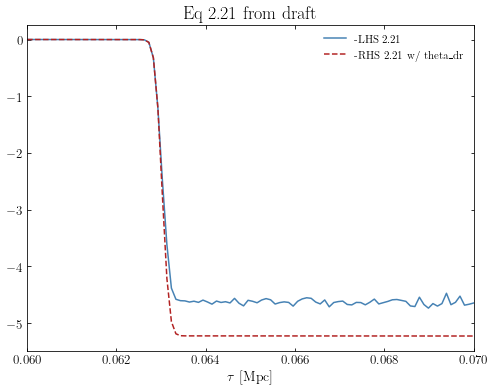

In [110]:
#2.21 from paper
plt.plot(tauu, lhsarr , label='-LHS 2.21')
plt.plot(tauu, rhsarr , '--',label = '-RHS 2.21 w/ theta_dr')


plt.title('Eq 2.21 from draft')
plt.xlabel('$\\tau$ [Mpc]')
plt.xlim(6e-2,7e-2)
# plt.ylim(1e-1,1e5)

plt.legend()
plt.show()

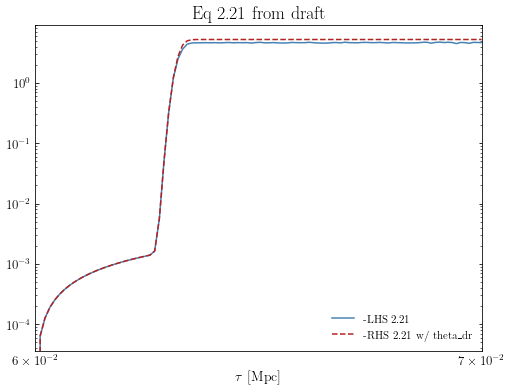

In [127]:
#2.21 from paper
plt.loglog(tauu, -1*lhsarr , label='-LHS 2.21')
plt.loglog(tauu, -1*rhsarr , '--',label = '-RHS 2.21 w/ theta_dr')


plt.title('Eq 2.21 from draft')
plt.xlabel('$\\tau$ [Mpc]')
plt.xlim(6e-2,7e-2)
# plt.ylim(1e-1,1e5)

plt.legend()

# plt.savefig('Figures/221_integrated.png')

plt.show()

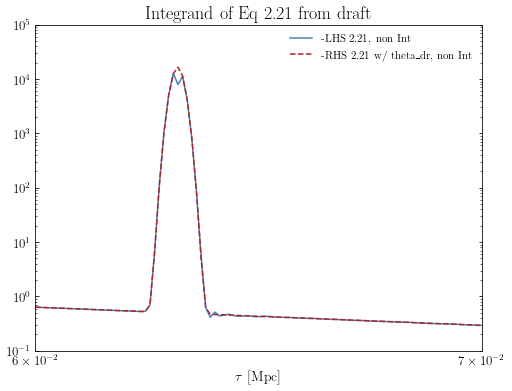

In [128]:
#2.21 Non Integrated from paper
plt.loglog(tauu, -1*lhs221NonInt(tauu) , label='-LHS 2.21, non Int')
# plt.loglog(tau_tests, 4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)*(3*phi_dot(tau_tests) - delta_chi_dot(tau_tests)), '--',label = 'RHS')
plt.loglog(tauu, -1*rhs221NonInt(tauu) , '--',label = '-RHS 2.21 w/ theta_dr, non Int')


# kappa_dot_taus*(3*phi_dot - delta_chi_dot)
plt.title('Integrand of Eq 2.21 from draft')
plt.xlabel('$\\tau$ [Mpc]')
plt.xlim(6e-2,7e-2)
plt.ylim(1e-1,1e5)


plt.legend()
plt.show()

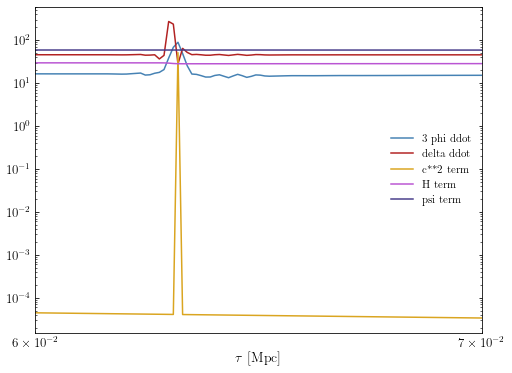

In [120]:
#LHS 2.21 Components, non int
plt.loglog(tauu, abs(3 *phi_ddot(tauu)) , label='3 phi ddot')
plt.loglog(tauu, abs(delta_chi_ddot(tauu)) , label='delta ddot')
plt.loglog(tauu, abs(cx2_chi(tauu) * k**2 * delta_chi(tauu)) , label='c**2 term')
plt.loglog(tauu, abs(aprime(tauu)/a(tauu) *theta_chi(tauu)) , label='H term')
plt.loglog(tauu, abs(k**2 *psi(tauu)) , label='psi term')

plt.xlabel('$\\tau$ [Mpc]')
plt.xlim(6e-2,7e-2)

plt.legend()
plt.show()


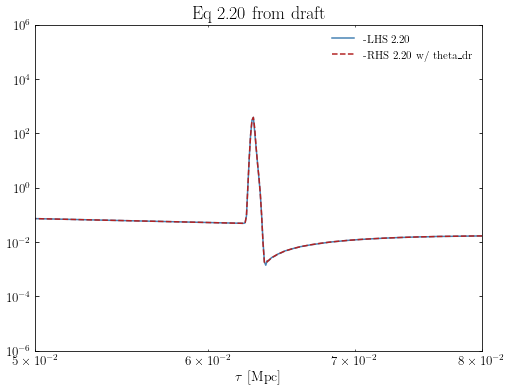

In [73]:
#2.20 from paper
plt.loglog(tau_tests, -1*lhs220(tau_tests) , label='-LHS 2.20')
# plt.loglog(tau_tests, 4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)*(3*phi_dot(tau_tests) - delta_chi_dot(tau_tests)), '--',label = 'RHS')
plt.loglog(tau_tests, -1*rhs220(tau_tests) , '--',label = '-RHS 2.20 w/ theta_dr')


# kappa_dot_taus*(3*phi_dot - delta_chi_dot)
plt.title('Eq 2.20 from draft')
plt.xlabel('$\\tau$ [Mpc]')
plt.xlim(5e-2,8e-2)
plt.ylim(1e-6,1e6)


plt.legend()
plt.show()

## 2.23

In [ ]:
def lhs223(tau):
    

In [16]:
from scipy.integrate import quadrature
import warnings

warnings.filterwarnings('ignore')

def lhs220(tau):
    return 3 *phi_ddot(tau) - delta_chi_ddot(tau) - cx2_chi(tau) * k**2 * delta_chi(tau) + aprime(tau)/a(tau) *theta_chi(tau) - k**2 *psi(tau)

def rhs220(tau):
    return 4/3*rho_idr(tau)/rho_idm(tau)*kappa_dot_taus(tau)*(3*phi_dot(tau) - delta_chi_dot(tau) - theta_dr(tau))

def lhs221(tau):
    return (3 *phi_ddot(tau) - delta_chi_ddot(tau) - cx2_chi(tau) * k**2 * delta_chi(tau) + aprime(tau)/a(tau) *theta_chi(tau) - k**2 *psi(tau))/(3*phi_dot(tau) - delta_chi_dot(tau) - theta_dr(tau))

def rhs221(tau):
    return 4/3*rho_idr(tau)/rho_idm(tau)*kappa_dot_taus(tau)

def lhs223(tau):
    return np.log((delta_chi_dot_arr[i](tau) - 3*phi_dot_arr[i](tau) - theta_dr_arr[i](tau))/(delta_chi_dot_arr[i](6e-2) - 3*phi_dot_arr[i](6e-2) - theta_dr_arr[i](6e-2)))

def lhs221int(tau):
    return quadrature(lhs221, 6e-2, tau, maxiter=100)[0]

def lhs221less(tau, aa, bb, cc, dd, ee):
    return (aa* 3 *phi_ddot(tau) - bb* delta_chi_ddot(tau) - cc*cx2_chi(tau) * k**2 * delta_chi(tau) + dd * aprime(tau)/a(tau) *theta_chi(tau) - ee* k**2 *psi(tau))/(3*phi_dot(tau) - delta_chi_dot(tau) - theta_dr(tau))

def lhs221lessint(tau, aa, bb, cc, dd, ee):
    return quadrature(lhs221less, 6e-2, tau, maxiter=100, args=(aa, bb, cc, dd, ee))[0]

In [32]:
delta_chi(tauu[50])

array(-0.99433398)

Text(0.5, 0, '$\\tau$ [Mpc]')

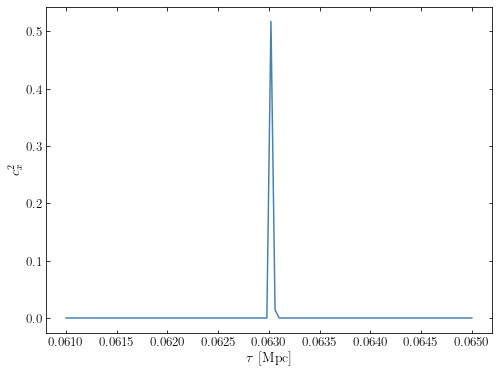

In [34]:
plt.plot(tauu, np.array([cx2_chi(t) for t in tauu]))
# plt.yscale('log')
plt.ylabel('$c_x^2$')
plt.xlabel('$\\tau$ [Mpc]')


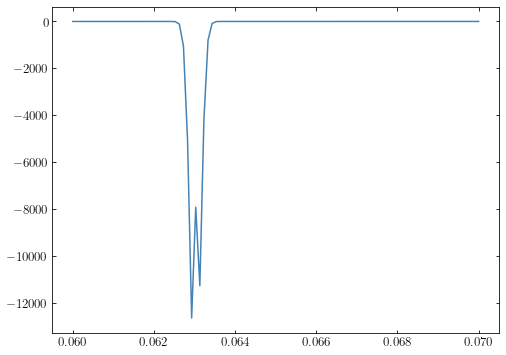

In [297]:
plt.plot(tauu, np.array([lhsLogan(t) for t in tauu]), label='lhs')


In [339]:
quadrature(lhsLogan, 6.1e-2, 6.5e-2, maxiter=500)

(-4.554625545483759, 0.08383034316893312)

In [338]:
rhsLogan(6.3e-2,2e-3)

-11.558151926766765

In [340]:
rhsLoganLess(6.3e-2,2e-3)

-2.0872610481295135

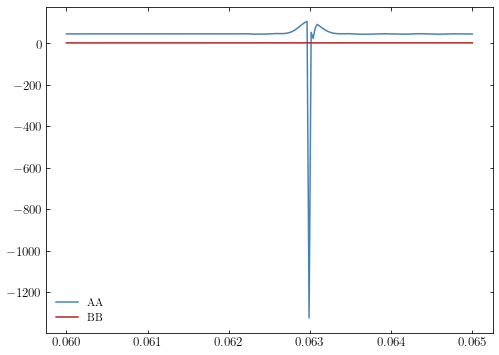

In [353]:
plt.plot(tauu, np.array([AA(t) for t in tauu]), label='AA')
plt.plot(tauu, np.array([BB(t) for t in tauu]), label='BB')
plt.legend()

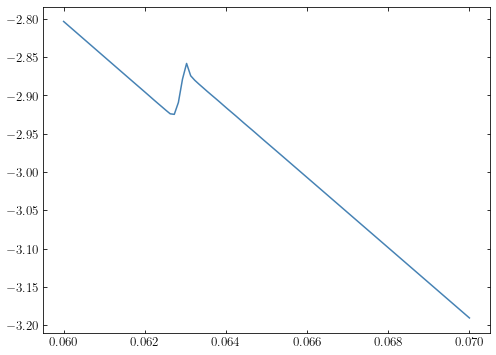

In [315]:
plt.plot(tauu, delta_chi_dot(tauu))

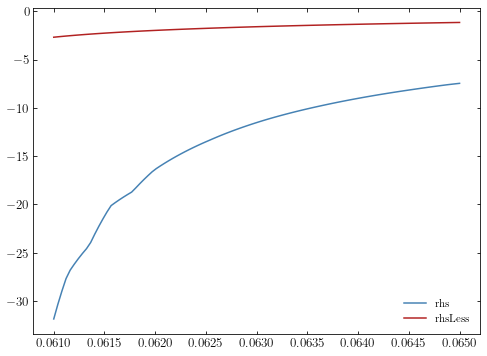

In [14]:
plt.plot(tauu, np.array([rhsLogan(t, 3e-3) for t in tauu]), label='rhs')
plt.plot(tauu, np.array([rhsLoganLess(t, 3e-3) for t in tauu]), label='rhsLess')
plt.legend()


Text(0.5, 0, '$\\tau$ [Mpc]')

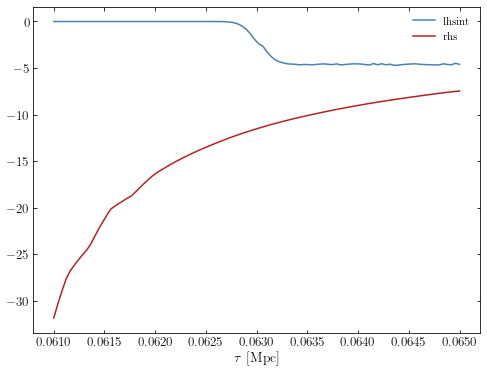

In [18]:
plt.plot(tauu, np.array([lhsLoganint(t) for t in tauu]), label='lhsint')
plt.plot(tauu, np.array([rhsLogan(t, 3e-3) for t in tauu]), label='rhs')
plt.legend()
plt.xlabel('$\\tau$ [Mpc]')


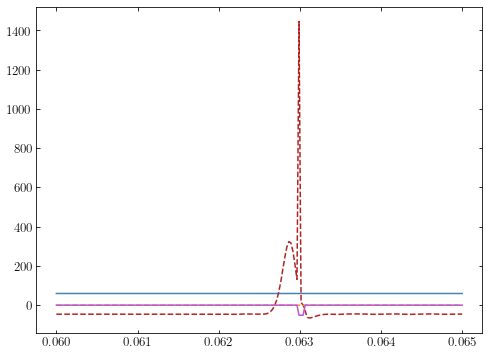

In [352]:
tauu = np.linspace(6e-2, 6.5e-2, 200)
plt.plot(tauu, k**2 *psi(tauu))
plt.plot(tauu, delta_chi_ddot(tauu), '--')
plt.plot(tauu, phi_dot(tauu), '--')

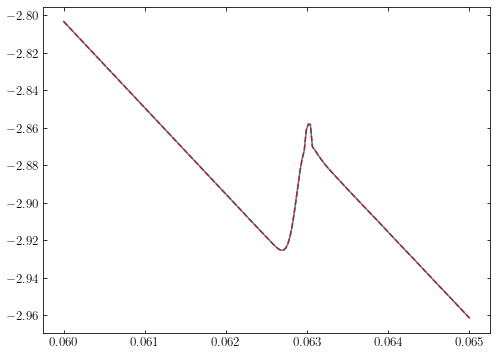

In [150]:
plt.plot(tauu, delta_chi.derivative()(tauu))
plt.plot(tauu, delta_chi_dot(tauu), '--')


(-1.0001065073865765, -0.9856694408425744)

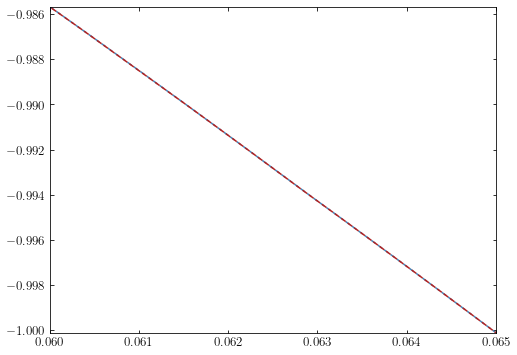

In [148]:
plt.plot(tauu, delta_chi(tauu), '--')
plt.plot(tau_data, delta_chi_data, '--')
plt.xlim(0.06,0.065)
plt.ylim(min(delta_chi(tauu)), max(delta_chi(tauu)))



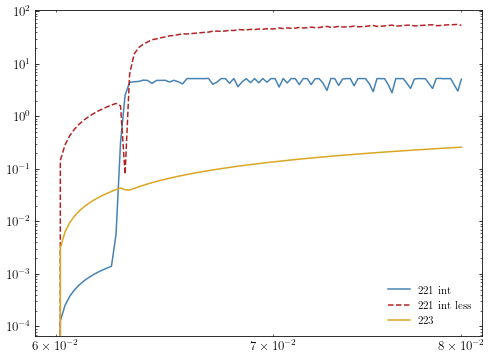

In [152]:
tauu = np.linspace(6e-2,8e-2,100)
plt.loglog(tauu, abs(np.array([lhs221int(t) for t in tauu])), label='221 int')
plt.loglog(tauu, abs(np.array([lhs221lessint(t, 1, 1, 1, 1, 0) for t in tauu])),'--', label='221 int less')
plt.loglog(tauu, lhs223(tauu), label='223')
plt.legend()


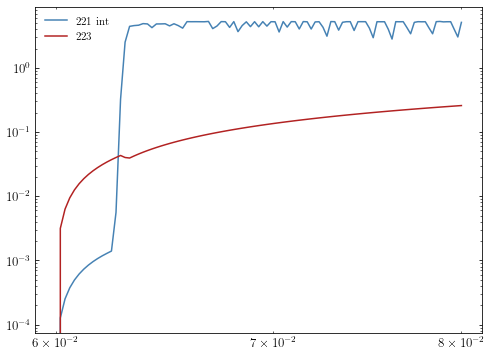

In [118]:
tauu = np.linspace(6e-2,8e-2,100)
warnings.filterwarnings('ignore')
plt.loglog(tauu, abs(np.array([lhs221int(t) for t in tauu])), label='221 int')
plt.loglog(tauu, lhs223(tauu), label='223')
plt.legend()


In [103]:
print(quadrature(lhs220, 6e-2, 7e-2, maxiter=500), quadrature(rhs220, 6e-2, 7e-2, maxiter=500))

/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (500) exceeded. Latest difference = 2.100612e-04
  warnings.warn(


(0.08794390962677512, 0.0002100612155191417) (0.09046568859385778, 9.762868645180056e-06)


/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (500) exceeded. Latest difference = 9.762869e-06
  warnings.warn(


In [89]:
print(quadrature(lhs221, 6e-2, 7e-2, maxiter=2000), quadrature(rhs221, 6e-2, 7e-2, maxiter=1000))

(4.64064978670342, 0.03452012014744277) (5.226827366027622, 2.9627650555141827e-08)


/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 3.452012e-02
  warnings.warn(


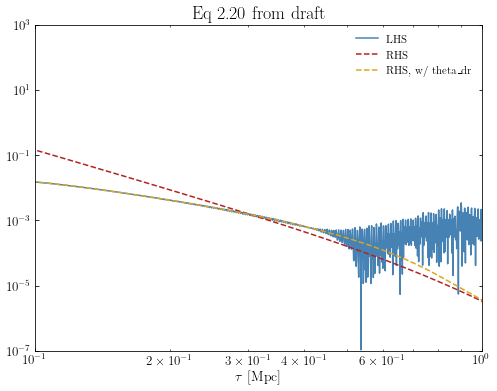

In [50]:
#2.20 from paper
plt.loglog(tau_tests, abs(3 *phi_ddot(tau_tests) - delta_chi_ddot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)), label='LHS')
plt.loglog(tau_tests, 4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)*(3*phi_dot(tau_tests) - delta_chi_dot(tau_tests)), '--',label = 'RHS')
plt.loglog(tau_tests, 4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)*(3*phi_dot(tau_tests) - delta_chi_dot(tau_tests) - theta_dr(tau_tests)), '--',label = 'RHS, w/ theta_dr')


# kappa_dot_taus*(3*phi_dot - delta_chi_dot)
plt.title('Eq 2.20 from draft')
plt.xlabel('$\\tau$ [Mpc]')
plt.xlim(1e-1,1e0)
plt.ylim(1e-7,1e3)


plt.legend()
plt.show()

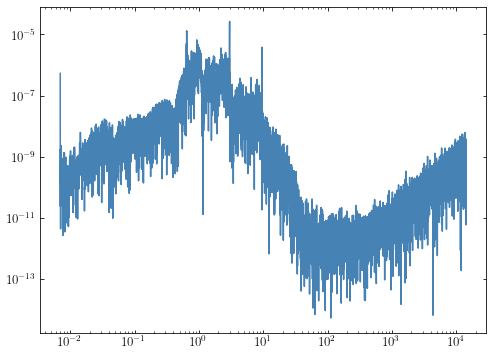

In [25]:
#Eq 2.15 from paper
# plt.loglog(tau_tests, abs(delta_chi_dot(tau_tests) + theta_chi(tau_tests) - 3*phi_dot(tau_tests)))
plt.loglog(tau_tests, abs(delta_chi_dot(tau_tests) + theta_chi(tau_tests) - 3*phi_dot(tau_tests)))
plt.show()


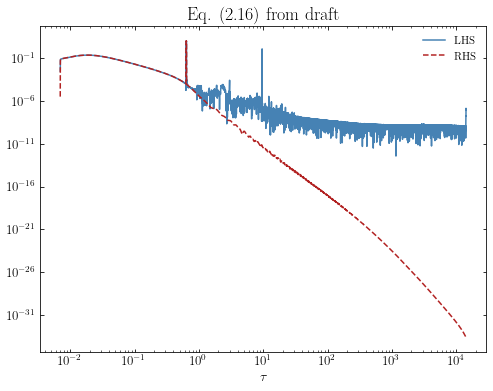

In [26]:
#left and right side of Eq 2.16 from paper
# plt.loglog(tau_tests,theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + H_interp(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests))
plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='LHS')

# plt.loglog(tau_tests, kappa_dot_taus(tau_tests)*(theta_chi(tau_tests) - theta_dr(tau_tests)))
plt.loglog(tau_tests, 4/3*rho_idr(tau_tests)/rho_idm(tau_tests)* kappa_dot_taus(tau_tests)*(theta_chi(tau_tests) - theta_dr(tau_tests)), '--', label = 'RHS')


# plt.loglog(tau_tests,H_interp(tau_tests) *theta_chi(tau_tests))

plt.title('Eq. (2.16) from draft')
plt.xlabel('$\\tau$')
plt.legend()



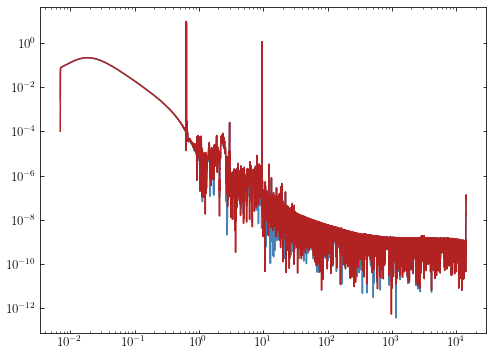

In [29]:
#some cancellation with theta_chi_dot and theta_chi is noisy
plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='abs(LHS)')

# plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests)  - k**2 *psi(tau_tests)),label='LHS')
# plt.loglog(tau_tests,abs( - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='LHS')


plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='')

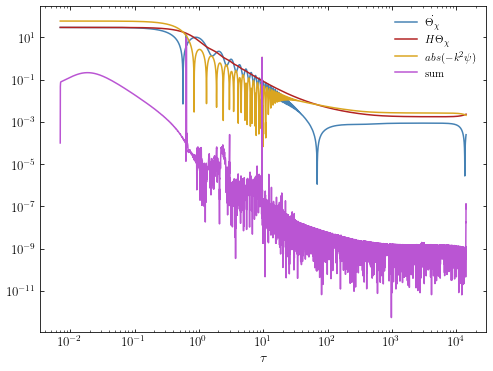

In [30]:
plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests)),label='$\dot{\Theta_\chi}$')
plt.loglog(tau_tests,abs( aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) ),label='$H \Theta_\chi$')
plt.loglog(tau_tests,abs( - k**2 *psi(tau_tests)),label='$abs(- k^2 \psi$)')
plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='sum')


plt.xlabel('$\\tau$')
plt.legend()
plt.show()



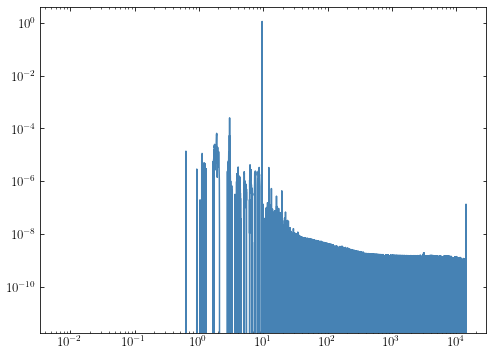

In [31]:
plt.loglog(tau_tests,theta_chi_dot(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests),label='sum')


(0.01, 1.0)

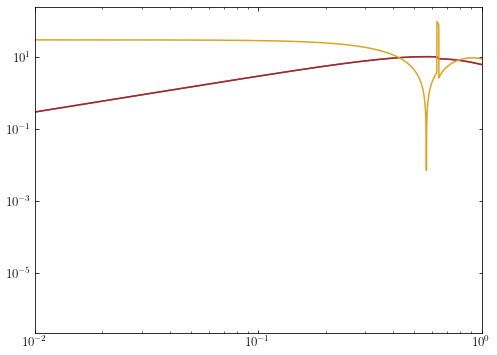

In [320]:
plt.loglog(tau_data, theta_data)
plt.loglog(tau_tests,theta_chi(tau_tests))
plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests)))
plt.xlim(1e-2,1e0)



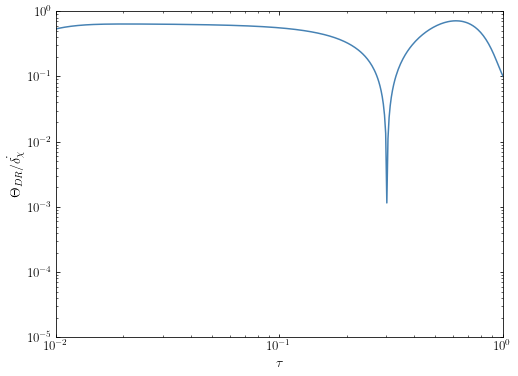

In [32]:
# plt.loglog(tau_data, abs(delta_chi_dot(tau_data)))
plt.loglog(tau_data, abs(theta_dr(tau_data))/abs(delta_chi_dot(tau_data)), label = 'theta_dr/delta_chi_dot')
# plt.legend()
plt.xlabel('$\\tau$')
plt.ylabel('$\Theta_{DR}/\dot{\delta_\chi}$')
plt.xlim(1e-2,1e0)
plt.ylim(1e-5,1e0)
plt.show()



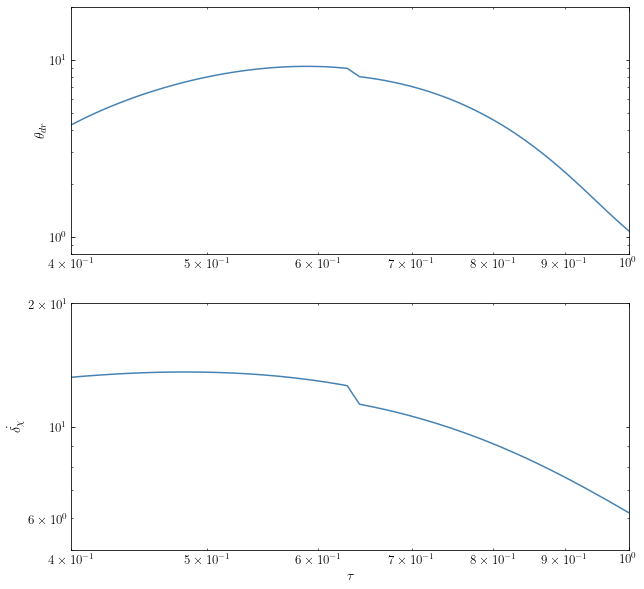

In [364]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.loglog(tau_data, abs(theta_dr(tau_data)))
plt.xlim(4e-1,1e0)
plt.ylim(8e-1,2e1)
plt.ylabel('$\\theta_{dr}$')



plt.subplot(2,1,2)
plt.loglog(tau_data, abs(delta_chi_dot(tau_data)))

# plt.legend()
plt.xlabel('$\\tau$')
plt.ylabel('$\dot{\delta_\chi}$')

plt.xlim(4e-1,1e0)
plt.ylim(5e-0,2e1)
plt.show()



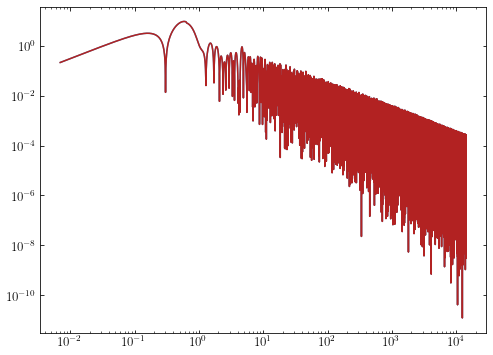

In [335]:
plt.loglog(tau_data, abs(theta_dr_data), label = 'theta_dr')
plt.loglog(tau_data,abs(theta_dr(tau_data)))



## Example plots

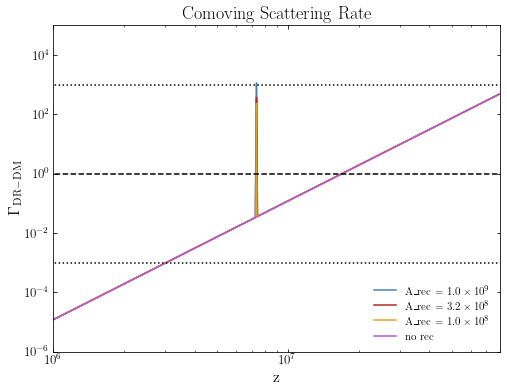

In [415]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_arr[i], kappa_dot_zs_arr[i](z_arr[i]), label='A_rec = ' + scientific_format(A_rec))

plt.plot(z_data_no_rec, kappa_dot_data_no_rec, label='no rec ')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(1e6,8e7)
plt.ylim(1e-6,1e5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

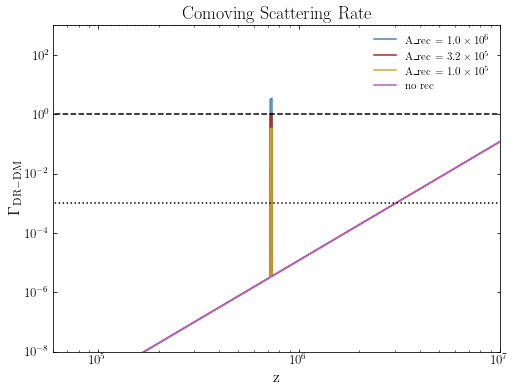

In [13]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_arr[i], kappa_dot_zs_arr[i](z_arr[i]), label='A_rec = ' + scientific_format(A_rec))

plt.plot(z_data_no_rec, kappa_dot_data_no_rec, label='no rec ')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e4,1e7)
plt.ylim(1e-8,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

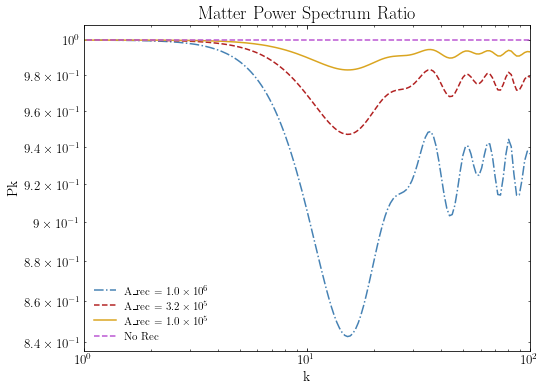

In [14]:
lines = ["-","--","-.",":"]
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(kk, Pk_arr[i]/Pks_no_rec,  ls = lines[i%len(lines)], label='A_rec = ' + scientific_format(A_rec))

plt.plot(kk,Pks_no_rec/Pks_no_rec, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Pk')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1,1e2)
plt.legend()
plt.show()

In [12]:
Rdark_arr = [4/3*rho_idr_arr[i](7e-2)/rho_idm_arr[i](7e-2) for i in range(len(rho_idr_arr))]

In [20]:
lhs_dat = 1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*-(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests))
lhs = UnivariateSpline(tau_tests,lhs_dat, s=0, k=1, ext=1)
# rhs_dat =  4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)
rhs_dat =  kappa_dot_taus(tau_tests)

rhs = UnivariateSpline(tau_tests, rhs_dat, s=0, k=1, ext=1)

def integral_lhs(tau, epsilon):
    return lhs.integral(tau-epsilon, tau+epsilon)

def new_lhs(tau, epsilon, theta_chi_func, theta_dr_func):
    return (theta_chi_arr[i](tau+epsilon) - theta_chi_arr[i](tau-epsilon))/(1/2(theta_chi_arr[i](tau+epsilon) + theta_chi_arr[i](tau-epsilon) + theta_dr_arr[i](tau+epsilon) + theta_dr_arr[i](tau-epsilon)))

<>:12: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:12: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_1437/2326163187.py:12: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  return (theta_chi_arr[i](tau+epsilon) - theta_chi_arr[i](tau-epsilon))/(1/2(theta_chi_arr[i](tau+epsilon) + theta_chi_arr[i](tau-epsilon) + theta_dr_arr[i](tau+epsilon) + theta_dr_arr[i](tau-epsilon)))


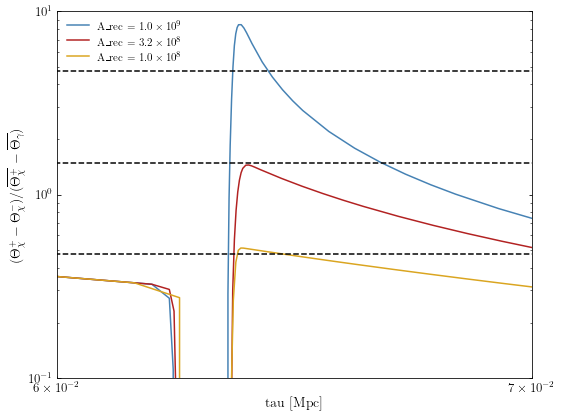

In [65]:
#Above A = 1e8, starts to saturate.
for i, A_rec in reversed(list(enumerate(A_recs))):
    # taus = np.linspace(6e-2, 7e-2,1000)
    taus = tau_arr[i]
    #Results are super dependent on epsilon
    epsilon = 5e-4
    plt.plot(taus, (theta_chi_arr[i](taus+epsilon) - theta_chi_arr[i](taus-epsilon))/(1/2*(theta_chi_arr[i](taus+epsilon) + theta_chi_arr[i](taus-epsilon) - theta_dr_arr[i](taus+epsilon) - theta_dr_arr[i](taus-epsilon))), label='A_rec = ' + scientific_format(A_rec))
    # plt.plot(taus, (np.exp(kappa_dot_taus_arr[i].integral(6e-2, 7e-2)/Rdark_arr[i]) -1*np.ones_like(taus)), '--', color='k')
    plt.plot(taus, kappa_dot_taus_arr[i].integral(6e-2, 7e-2)*Rdark_arr[i] *np.ones_like(taus), '--', color='k')


 
plt.xlim(6e-2,7e-2)
plt.ylim(1e-1,1e1)
plt.xlabel('tau [Mpc]')
plt.ylabel('$(\Theta_\chi^+ - \Theta_\chi^-)/ (\overline{\Theta_\chi^+} - \overline{\Theta_\gamma})$')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()

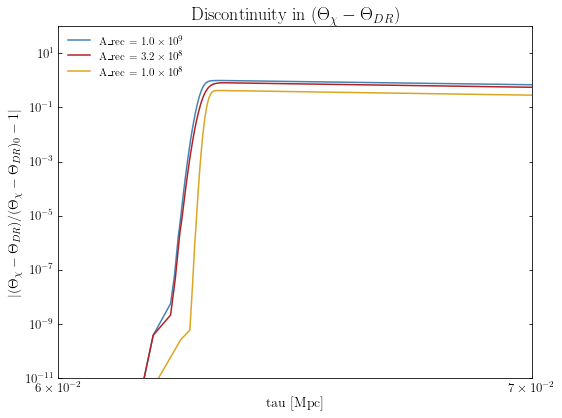

In [66]:
#Above A = 1e8, starts to saturate.
for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = tau_arr[i]
    plt.plot(taus, abs((theta_chi_arr[i](taus) - theta_dr_arr[i](taus))/(theta_chi_no_rec(taus) - theta_dr_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))
    # plt.plot(taus, (np.exp(kappa_dot_taus_arr[i].integral(6e-2, 7e-2)/Rdark_arr[i]) -1*np.ones_like(taus)), '--', color='k')

 
plt.xlim(6e-2,7e-2)
plt.ylim(1e-11,1e2)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\Theta_\chi - \Theta_{DR})/ (\Theta_\chi - \Theta_{DR})_0 - 1|$')
plt.legend(loc='upper left')
plt.title('Discontinuity in $(\Theta_\chi - \Theta_{DR})$')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()

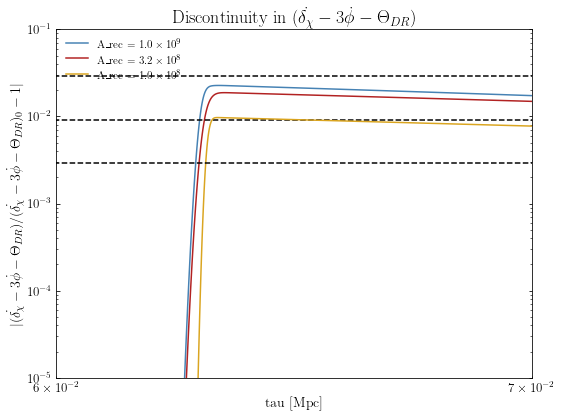

In [90]:
#Above A = 1e8, starts to saturate.
for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = tau_arr[i]
    plt.plot(taus, abs((delta_chi_dot_arr[i](taus) - 3*phi_dot_arr[i](taus) - theta_dr_arr[i](taus))/(delta_chi_dot_no_rec(taus) - 3*phi_dot_no_rec(taus) - theta_dr_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))
    plt.plot(taus, (np.exp(kappa_dot_taus_arr[i].integral(6e-2, 7e-2)/Rdark_arr[i]) -1*np.ones_like(taus)), '--', color='k')

 
plt.xlim(6e-2,7e-2)
plt.ylim(1e-5,1e-1)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{DR})/ (\dot{\delta_\chi} - 3 \dot\phi - \Theta_{DR})_0 - 1|$')
plt.legend(loc='upper left')
plt.title('Discontinuity in $(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{DR})$')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()

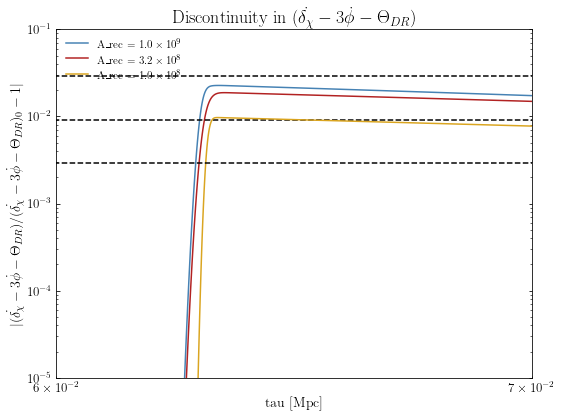

In [19]:
#Above A = 1e8, starts to saturate.
for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = tau_arr[i]
    plt.plot(taus, abs((delta_chi_dot_arr[i](taus) - 3*phi_dot_arr[i](taus) - theta_dr_arr[i](taus))/(delta_chi_dot_no_rec(taus) - 3*phi_dot_no_rec(taus) - theta_dr_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))
    plt.plot(taus, (np.exp(kappa_dot_taus_arr[i].integral(6e-2, 7e-2)/Rdark_arr[i]) -1*np.ones_like(taus)), '--', color='k')

 
plt.xlim(6e-2,7e-2)
plt.ylim(1e-5,1e-1)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{DR})/ (\dot{\delta_\chi} - 3 \dot\phi - \Theta_{DR})_0 - 1|$')
plt.legend(loc='upper left')
plt.title('Discontinuity in $(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{DR})$')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()

## Compare numerics to analytical estimate of discontinuity

In [263]:
#Find z_recoupling and calculate S_inv at that point
z_rec_idx = np.argmin(abs(bkg_zs_no_rec - (T_rec/(2.73*xi) - 1)))
S_inv = 4/3*rho_idr_no_rec[z_rec_idx]/rho_idm_no_rec[z_rec_idx]

In [264]:
#Calculate delta_tau * Gamma_{DM-DR, peak} ~= integral(Gamma_{DM-DR} dtau)

myzs = np.logspace(5.5,6.3,10000) #Assume peak occurs in this range (which it does for T_rec = 6e5)
dmu_peaks = []
dTaus = []
for i, A_rec in enumerate(A_recs):
    mytaus = thermo_tau_arr[i](myzs)
    peak_idxs = np.where(kappa_dot_taus_arr[i](mytaus)>=1e-3) #indices in tau for which DM is recoupled, assuming the peak is greater than 1e-3
    peak_taus = mytaus[peak_idxs]
    dTau = np.max(peak_taus) - np.min(peak_taus) #conformal time spent in peak
    dmu_peak = np.max(kappa_dot_taus_arr[i](peak_taus)) #Max comoving rate during recoupling

    dmu_peaks.append(dmu_peak)
    dTaus.append(dTau)

ValueError: zero-size array to reduction operation maximum which has no identity

In [206]:
# plt.plot(peak_taus, kappa_dot_taus_arr[2](peak_taus))
# plt.show()

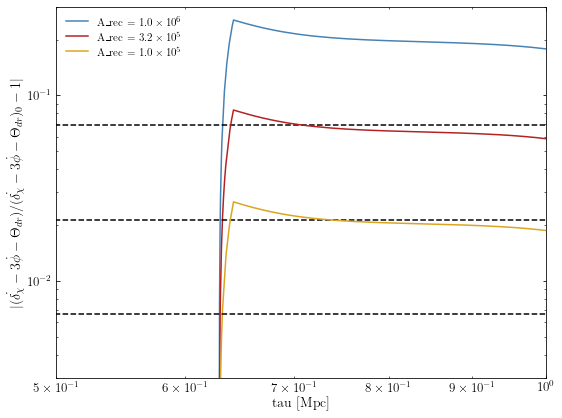

In [18]:
A_recs = [1e5, 10**(5.5), 1e6]

for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = tau_arr[i]
    plt.plot(taus, abs((delta_chi_dot_arr[i](taus) - 3*phi_dot_arr[i](taus) - theta_dr_arr[i](taus))/(delta_chi_dot_no_rec(taus) - 3*phi_dot_no_rec(taus) - theta_dr_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))
 
    plt.plot(np.linspace(0.1,1,100), (np.exp(dTaus[i]*S_inv*dmu_peaks[i])-1)*np.ones(100), 'k--')

plt.xlim(5e-1,1e0)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{dr})/ (\dot{\delta_\chi} - 3 \dot\phi - \Theta_{dr})_0 - 1|$')

plt.legend(loc='upper left')

plt.yscale('log')
plt.xscale('log')
plt.ylim(3e-3,3e-1)


plt.tight_layout()

# plt.savefig('Figures/delta_chi_compare2.pdf')

## Generate Data (shouldn't need to touch unless re-running CLASS)

In [213]:
from classy import Class

In [214]:
def getPk(classObj):
    kk = np.logspace(-4,np.log10(pk_max),500) # k in h/Mpc
    Pk = [] # P(k) in (Mpc/h)**3
    h = classObj.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk.append(classObj.pk(k*h,z_pk)*h**3) # function .pk(k,z)
    return Pk;

def getPkRatio(classObj1, classObj2):
    #Returns the ratio of the power spectrum of 1 to 2
    return[getPk(classObj1)[i]/getPk(classObj2)[i] for i in range(len(kk))]
    

def getdmu_idm_dr(classObj):
    return classObj.get_thermodynamics()['dmu_idm_dr']
    
def getzs(classObj):
    return classObj.get_thermodynamics()['z']

def getH(classObj):
    zs = np.flip(classObj.get_background()['z'])
    Hs = np.flip(classObj.get_background()['H [1/Mpc]'])
    return UnivariateSpline(zs, Hs, k=1.0, s=0.0)


def getDat(classObj):
    dmu_idm_dr = getdmu_idm_dr(classObj);
    zs = getzs(classObj);
    Hspline = getH(classObj);
    
    return dmu_idm_dr, zs, Hspline

def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, h =0.67556, xi_idr = 0.3 ):
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr * h**2 

    if T_rec >= (xi_idr * 2.73) * (1+z) and (xi_idr*2.73) * (1+z) > T_rec*0.99:
        return base_rate*(1+A_rec)
    else:
        return base_rate

def save_class_obj(class_obj,A_rec):
    model = class_obj
    data_file=h5pydir+'class_model_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'w') as f:    
        # Scalar group
        data = model.get_perturbations()['scalar']
        sub_group = f.create_group('scalar')
        for i, k in enumerate(BM_KS):
            sub_sub_group = sub_group.create_group(f'k={k}')
            d = data[i]
            for key, val in d.items():
                sub_sub_group.create_dataset(key, data=val)
        
        # Background group
        data = model.get_background()
        sub_group = f.create_group('background')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)
        
        # Thermo group
        data = model.get_thermodynamics()
        sub_group = f.create_group('thermodynamics')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

        # Power Spectrum group
        data = getPk(model)
        sub_group = f.create_group('power_spectrum')
        sub_group.create_dataset('kk', data=kk)
        sub_group.create_dataset('Pk', data=data) 

In [215]:
commonset = {
    'omega_b': 0.022032,
    'omega_cdm': omega0_cdm,
    'h': 0.67556,
    'A_s': 2.215e-9,
    'n_s': 0.9619,
    'tau_reio': 0.0925,
    'output': 'tCl,pCl,lCl,mPk',
    'lensing': 'yes',
    'P_k_max_1/Mpc': pk_max,
    'z_pk': 0.0,
    'k_output_values':'10',
}

idrset = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    'nindex_idm_dr': 4.0, 
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 1.0e0,
    'rec_case': 4, #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling 
}

In [328]:
# A_recs = [1e5, 10**(5.5), 1e6]
A_recs = [1e6, 1e7, 1e8]
# sigma_fac = 0.002
sigma_fac = 0.001
# A_recs = [1]

for A_rec in A_recs:
    cos = Class()
    cos.set(commonset)
    cos.set(idrset)
    cos.set({
        'rec_case': 3,
        'A_rec':A_rec,
        'T_rec':T_rec*10,
        'sigma' : sigma_fac*T_rec*10 #Gaussian width
        })
    cos.compute() 

    save_class_obj(cos,A_rec)
    
    # clear content of cos (to reuse it for another model)
    cos.struct_cleanup()
    # reset parameters to default
    cos.empty()

In [80]:
f = dict(scalar = cos.get_perturbations()['scalar'][0], thermodynamics = cos.get_thermodynamics(), background = cos.get_background())
tau_data = np.array(f['scalar']['tau [Mpc]'])
delta_chi_data = np.array(f['scalar']['delta_idm_dr'])
phi_data = np.array(f['scalar']['phi'])
kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr'])) #!This isn't kappadot, this is kappadot/Rdark
z_data = np.flip(np.array(f['thermodynamics']['z']))
thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
cx2_data = np.flip(np.array(f['thermodynamics']['c_idm_dr^2']))

theta_data = np.array(f['scalar']['theta_idm_dr'])
theta_dr_data = np.array(f['scalar']['theta_idr'])

psi_data = np.array(f['scalar']['psi'])

rho_idr_data = np.array(f['background']['(.)rho_idr'])
rho_idm_data = np.array(f['background']['(.)rho_idm_dr'])
bkg_tau_data = np.array(f['background']['conf. time [Mpc]'])

rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
delta_chi_dot = delta_chi.derivative()
delta_chi_ddot = delta_chi_dot.derivative()

phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
phi_dot = phi.derivative()
phi_ddot = phi_dot.derivative()

theta_chi = UnivariateSpline(tau_data, theta_data, **spline_pars)
theta_chi_dot = theta_chi.derivative()
theta_dr = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

psi = UnivariateSpline(tau_data, psi_data, **spline_pars)
cx2_chi = UnivariateSpline(thermo_tau_data, cx2_data, **spline_pars)

kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)
thermo_zs = UnivariateSpline(thermo_tau_data, z_data, **spline_pars)


a_data = 1/(1+z_data)
a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
aprime = a.derivative()

Pks = getPk(cos)

In [106]:
scientific_format(thermo_taus.derivative()(thermo_zs(6.3e-2))*T_rec*10*sigma_fac/(2.73 * xi))

'$-1.3 \\times 10^{-4}$'

In [329]:
#This is lhs of 2.16 with (theta_dr - theta_chi) divided over

# lhs_dat = -(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests))
lhs_dat = 1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*-(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests))
lhs = UnivariateSpline(tau_tests,lhs_dat, s=0, k=1, ext=1)
# rhs_dat =  4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)
rhs_dat =  kappa_dot_taus(tau_tests)

rhs = UnivariateSpline(tau_tests, rhs_dat, s=0, k=1, ext=1)

def integral_lhs(tau, epsilon):
    return lhs.integral(tau-epsilon, tau+epsilon)

def integral_rhs(tau, epsilon):
    return rhs.integral(tau-epsilon, tau+epsilon)

In [330]:
lhs_integrals = [integral_lhs(tau, 5e-3) for tau in tau_tests]
rhs_integrals = [integral_rhs(tau, 5e-3) for tau in tau_tests]


In [170]:
print(rhs.integral(6e-2,7e-2), lhs.integral(6e-2,7e-2))

0.36691108605553213 0.33612983777882455


In [175]:
Rdark = 4/3*rho_idr(7e-2)/rho_idm(7e-2) 
#? Looks like there was extra factor of Rdark! Now good agreement!
# kappa_int = kappa_dot_taus.integral(6e-2,7e-2)*Rdark
kappa_int = kappa_dot_taus.integral(6e-2,7e-2) #! This is integral of kappadot/Rdark

In [161]:
tau_rec = 6.3e-2
A_peak = thermo_taus.derivative()(thermo_zs(tau_rec))/(2.73 * xi )*A_rec*-((1+thermo_zs(tau_rec))/(1e7))**4 * 0.12038 
A_peak

0.36625641120472574

In [162]:
1/(-((1+thermo_zs(6.3e-2))/(1e7))**4 * 0.12038 )

-28.607496208861562

In [163]:
kappa_int/A_peak

1.001787122070159

(0.03, 0.09)

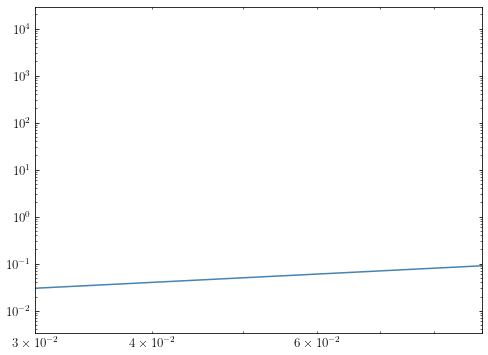

In [164]:
plt.loglog(tau_tests,thermo_taus(thermo_zs(tau_tests)))
plt.xlim(3e-2, 9e-2)

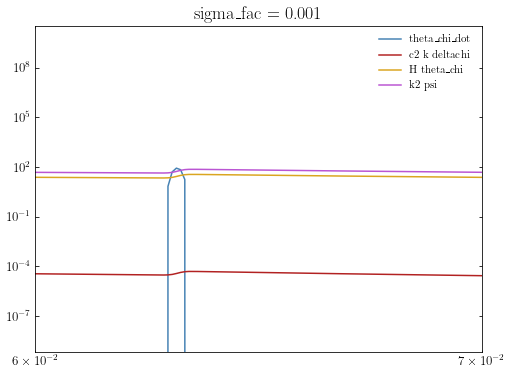

In [349]:
# 1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*-(  - k**2 *psi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests))
plt.loglog(tau_tests,1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*-(theta_chi_dot(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests)), label='theta_chi_dot')
plt.loglog(tau_tests,1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*(- cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests)), label='c2 k deltachi')
plt.loglog(tau_tests,1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*(aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests)), label='H theta_chi')
plt.loglog(tau_tests,1/(4/3*rho_idr(tau_tests)/rho_idm(tau_tests))*( k**2 *psi(tau_tests))/(theta_chi(tau_tests) - theta_dr(tau_tests)), label='k2 psi')


plt.xlim(6e-2, 7e-2)
# plt.ylim(1e-5,1e2)
plt.title('sigma_fac = {}'.format(sigma_fac))
plt.legend()
plt.show()

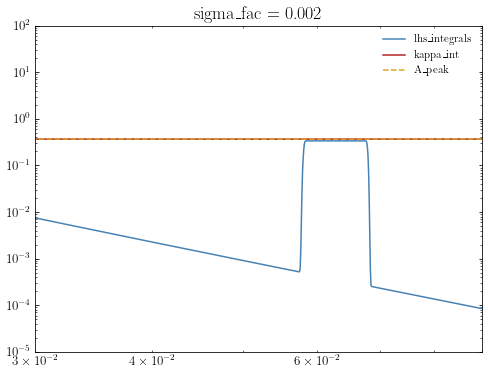

In [165]:
plt.loglog(tau_tests,lhs_integrals, label='lhs_integrals')
plt.loglog(tau_tests, np.ones_like(tau_tests)*kappa_int, label='kappa_int')
plt.loglog(tau_tests, np.ones_like(tau_tests)*A_peak, '--',label='A_peak')
plt.xlim(3e-2, 9e-2)
plt.ylim(1e-5,1e2)
plt.title('sigma_fac = {}'.format(sigma_fac))
plt.legend()
plt.show()

(1e-07, 100000.0)

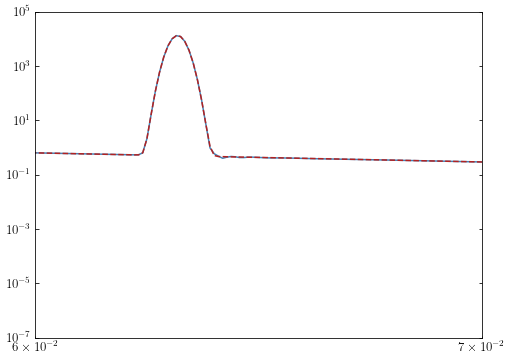

In [34]:
plt.loglog(tau_tests, lhs(tau_tests))
plt.loglog(tau_tests, rhs(tau_tests), '--')
plt.xlim(6e-2, 7e-2)
plt.ylim(1e-7,1e5)

In [35]:
lhs.integral(6e-2,7e-2)

5.226499985834897

(1e-07, 1000.0)

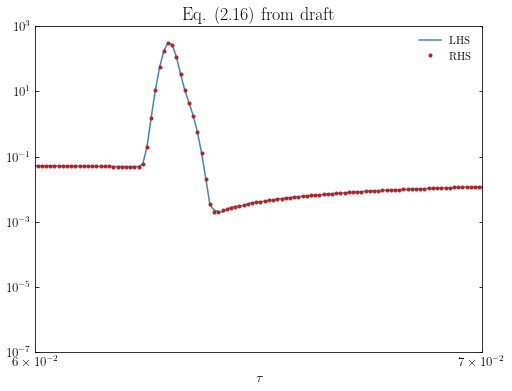

In [175]:
#Shorter Recoupling

#left and right side of Eq 2.16 from paper
tau_tests = np.geomspace(tau_data[0],tau_data[-1], int(1e4))

plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='LHS')
plt.loglog(tau_tests, abs(4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)*(theta_chi(tau_tests) - theta_dr(tau_tests))), '.', label = 'RHS')

plt.title('Eq. (2.16) from draft')
plt.xlabel('$\\tau$')
plt.legend()

plt.xlim(6e-2, 7e-2)
plt.ylim(1e-7,1e3)


(1e-07, 1000.0)

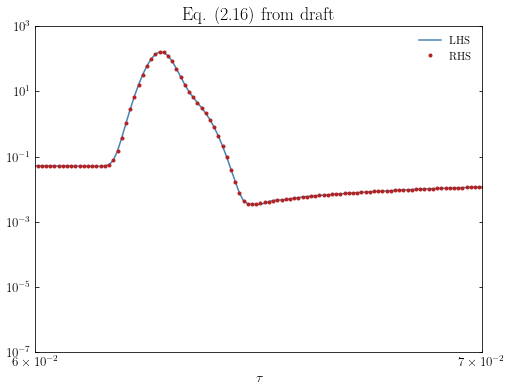

In [34]:
#Shorter Recoupling

#left and right side of Eq 2.16 from paper
tau_tests = np.geomspace(tau_data[0],tau_data[-1], int(1e4))

plt.loglog(tau_tests,abs(theta_chi_dot(tau_tests) - cx2_chi(tau_tests) * k**2 * delta_chi(tau_tests) + aprime(tau_tests)/a(tau_tests) *theta_chi(tau_tests) - k**2 *psi(tau_tests)),label='LHS')
plt.loglog(tau_tests, abs(4/3*rho_idr(tau_tests)/rho_idm(tau_tests)*kappa_dot_taus(tau_tests)*(theta_chi(tau_tests) - theta_dr(tau_tests))), '.', label = 'RHS')

plt.title('Eq. (2.16) from draft')
plt.xlabel('$\\tau$')
plt.legend()

plt.xlim(6e-2, 7e-2)
plt.ylim(1e-7,1e3)


In [325]:
A_rec = A_recs[-1]
base_rate = 1 * ((1+z_data)/(1e7))**4 * 0.12038 
T_idr = 2.73 * xi * (1+z_data)
sigma2 = (sigma_fac*T_rec*10)**2
delta = T_idr - T_rec*10
gauss = np.exp(-delta**2/(2*sigma2))/np.sqrt(2*np.pi*sigma2)
my_dmu_idm_dr_gauss = base_rate*(1 + A_rec * gauss)


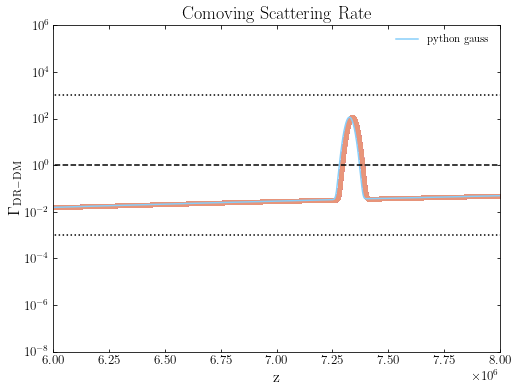

In [326]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_data, kappa_dot_zs(z_data))
    plt.plot(np.flip(z_data), np.flip(kappa_dot_data), '.')

plt.plot(z_data, my_dmu_idm_dr_gauss, label='python gauss')
# plt.plot(z_data_no_rec, kappa_dot_data_no_rec, label='no rec ')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e6,8e6)
plt.ylim(1e-8,1e6)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

Text(0, 0.5, 'dmu_idm_dr')

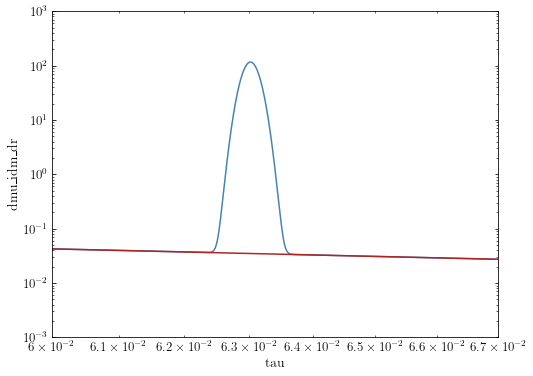

In [323]:
plt.loglog(thermo_tau_data, kappa_dot_taus(thermo_tau_data))
plt.loglog(thermo_tau_data, base_rate)

plt.xlim(6e-2,6.7e-2)
plt.ylim(1e-3,1e3)
plt.xlabel('tau')
plt.ylabel('dmu_idm_dr')

In [185]:
rec_tau_idxs = np.argwhere(np.logical_and(thermo_tau_data > 6e-2, thermo_tau_data < 6.7e-2)).squeeze()
np.exp(Rdark*(np.trapz(kappa_dot_taus(thermo_tau_data[rec_tau_idxs]), thermo_tau_data[rec_tau_idxs]) - np.trapz(base_rate[rec_tau_idxs], thermo_tau_data[rec_tau_idxs]))) 

110.14559763717263

In [199]:
np.exp(kappa_dot_taus.integral(6e-2,7e-2)/Rdark)-1

0.02902092509666221

In [201]:
kappa_dot_taus.integral(6e-2,7e-2)/Rdark

0.02860779201605767

In [211]:
tau_recs = np.logspace(np.log10(6e-2),np.log10(7e-2),100)
np.max(abs((delta_chi_dot(tau_recs) - 3*phi_dot(tau_recs) - theta_dr(tau_recs))/(delta_chi_dot_no_rec(tau_recs) - 3*phi_dot_no_rec(tau_recs) - theta_dr_no_rec(tau_recs)) - 1))/(kappa_dot_taus.integral(6e-2,7e-2)/Rdark)

0.7937968698747687

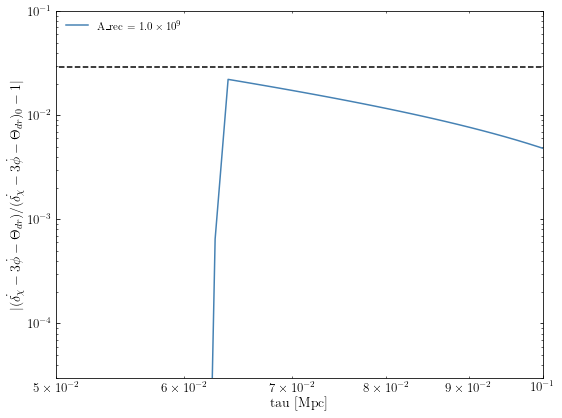

In [200]:
A_recs = [1e9]

for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(taus, abs((delta_chi_dot(taus) - 3*phi_dot(taus) - theta_dr(taus))/(delta_chi_dot_no_rec(taus) - 3*phi_dot_no_rec(taus) - theta_dr_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))

    # plt.plot(np.linspace(0.1,1,100), (np.exp(dTaus[i]*S_inv*dmu_peaks[i])-1)*np.ones(100), 'k--')
    plt.plot(taus, np.exp(kappa_dot_taus.integral(6e-2,7e-2)/Rdark)-1*np.ones_like(taus), 'k--')


plt.xlim(5e-2,1e-1)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{dr})/ (\dot{\delta_\chi} - 3 \dot\phi - \Theta_{dr})_0 - 1|$')

plt.legend(loc='upper left')

plt.yscale('log')
plt.xscale('log')
plt.ylim(3e-5,1e-1)


plt.tight_layout()

# plt.savefig('Figures/delta_chi_compare2.pdf')

In [116]:
def discont(tau, epsilon):
    return delta_chi_dot(tau+epsilon) - 3*phi_dot(tau + epsilon) - theta_dr(tau + epsilon)
    # return delta_chi_dot(tau+epsilon) - 3*phi_dot(tau + epsilon) 

def discont_deriv(tau, epsilon):
    return delta_chi_dot.derivative()(tau+epsilon) - 3*phi_dot.derivative()(tau + epsilon) - theta_dr.derivative()(tau + epsilon)

def discont_ratio(tau, epsilon):
    return discont(tau, epsilon)/discont(tau,-epsilon)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_51116/973600123.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(taus, np.log(discont_ratio(taus, 1e-4)), label='A_rec = ' + scientific_format(A_rec))


(0.05, 0.08)

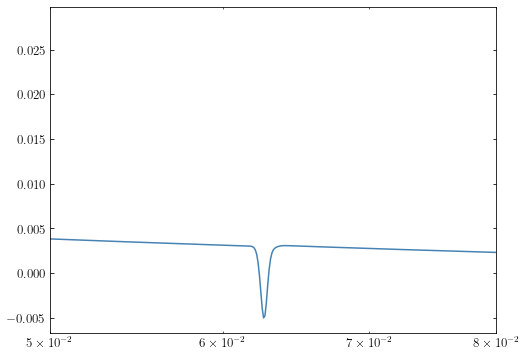

In [120]:
plt.plot(taus, np.log(discont_ratio(taus, 1e-4)), label='A_rec = ' + scientific_format(A_rec))
plt.xscale('log')
plt.xlim(5e-2,8e-2)
# plt.ylim(2e0,5e0)

(2.0, 5.0)

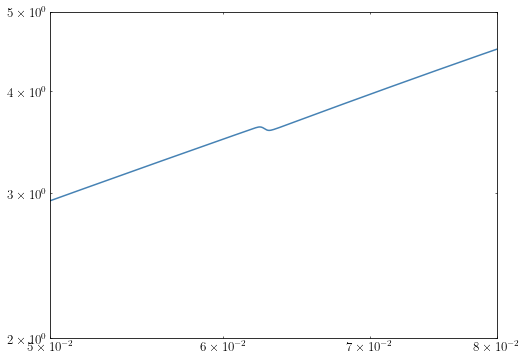

In [60]:
plt.loglog(taus, abs(discont(taus, 0)), label='A_rec = ' + scientific_format(A_rec))
plt.xlim(5e-2,8e-2)
plt.ylim(2e0,5e0)

In [73]:
newtaus = np.geomspace(1e-2,1e-1, int(1e4))
idxs = np.argwhere(discont_deriv(newtaus,0) > 0 )
print(np.min(idxs), np.max(idxs))
discont(newtaus[np.max(idxs)], 0) - discont(newtaus[np.min(idxs)], 0)

7948 7990


0.03497262290619396

In [61]:
np.argmax(discont_deriv(taus, 0))

1509

In [62]:
taus[1509]

0.0626309401333678

(0.05, 0.08)

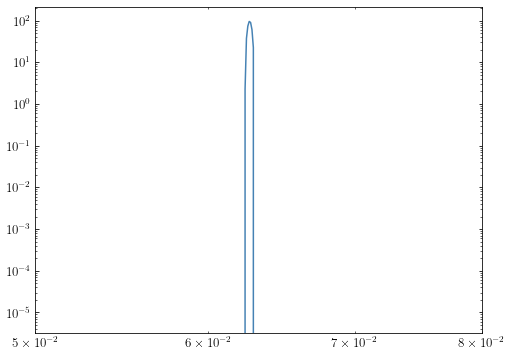

In [58]:
plt.loglog(taus, discont_deriv(taus, 0), label='A_rec = ' + scientific_format(A_rec))
plt.xlim(5e-2,8e-2)



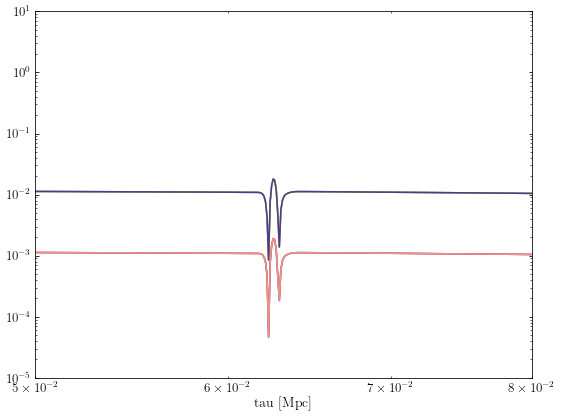

In [48]:
A_recs = [1e5, 10**(5.5), 1e6]

for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = np.geomspace(tau_data[0],tau_data[-1], int(1e4))
    plt.plot(taus, abs(discont(taus, 1e-4) - discont(taus, -1e-4)), label='A_rec = ' + scientific_format(A_rec))
    plt.plot(taus, abs(discont(taus, 1e-5) - discont(taus, -1e-5)), label='A_rec = ' + scientific_format(A_rec))

    # plt.plot(taus, abs(discont(taus, 1e-2) - discont(taus, -1e-2)), label='A_rec = ' + scientific_format(A_rec))
    # plt.plot(taus, abs(discont(taus, 5e-2) - discont(taus, -5e-2)), label='A_rec = ' + scientific_format(A_rec))


plt.xlabel('tau [Mpc]')
# plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi - \Theta_{dr})/ (\dot{\delta_\chi} - 3 \dot\phi - \Theta_{dr})_0 - 1|$')

# plt.legend(loc='upper left')

plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-2,8e-2)
plt.ylim(1e-5,1e1)


plt.tight_layout()

# plt.savefig('Figures/delta_chi_compare2.pdf')

In [ ]:
LambdaCDM = Class()
LambdaCDM.set(commonset)
LambdaCDM.compute()
LambdaCDMPk = getPk(LambdaCDM);

In [ ]:
idrNoRec = Class()
idrNoRec.set(commonset)
idrNoRec.set(idrset)

idrNoRec.compute()

In [ ]:
model = idrNoRec
with h5py.File(h5pydir+'class_model_data_no_rec.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 